In [121]:
import os
import sys
import time
import numpy as np
import pandas as pd

from collections import defaultdict
from matplotlib import pyplot as plt

sys.path.append('..')
sys.path.append('../..')

from library import ModelStatistics, SemanticHeterogenityRegularizer
from library import custom_fit_offline, weigh_average

from topicnet.cooking_machine import Dataset

import artm

## Lenta 1000 100

In [2]:
DATA_PATH = '../data/lenta_1000_100.vw'
BATCH_PATH = '../data/lenta_1000_100_batches'
DICT_PATH = '../data/lenta_1000_100.dict'

batch_vectorizer_lenta = artm.BatchVectorizer(
    data_path=DATA_PATH,
    data_format='vowpal_wabbit', 
    target_folder=BATCH_PATH
)

dictionary_lenta = artm.Dictionary()
if not os.path.isfile(DICT_PATH):
    dictionary_lenta.gather(data_path=batch_vectorizer_lenta.data_path)
    dictionary_lenta.save(DICT_PATH)
dictionary_lenta.load(DICT_PATH)

### Basic initialization

In [3]:
basic_model_lenta = artm.ARTM(num_topics=2, cache_theta=True)
basic_model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
basic_model_lenta.initialize(dictionary_lenta)

In [4]:
basic_model_lenta.fit_offline(batch_vectorizer_lenta, 3)

basic_lenta_statistics = ModelStatistics(basic_model_lenta)
basic_lenta_statistics.calculate_n(batch_vectorizer_lenta)
basic_lenta_stat = basic_lenta_statistics.calculate_topic_statistics(batch_vectorizer_lenta, recalculate_n=True)

### Perfect initialization

In [58]:
model_lenta = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta.initialize(dictionary_lenta)

In [59]:
(_, old_pwt) = model_lenta.master.attach_model(model=model_lenta.model_pwt)

pwt = model_lenta.get_phi()

In [60]:
def calculate_word2doc(vw_text, doc_id):
    word2doc = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

    current_modality = 'errors'
    for vw, doc in zip(vw_text, doc_id):
        for part in vw.split()[1:]:
            if part.startswith('|'):
                current_modality = part[1:]
            else:
                word2doc[current_modality][part][doc] += 1

    return word2doc

In [61]:
def calculate_word2tag(word2doc, doc2tag):
    word2tag = defaultdict(lambda: defaultdict(int))
    for modality in word2doc.keys():
        for word in word2doc[modality].keys():
            for doc in word2doc[modality][word].keys():
                word2tag[word][doc2tag[doc]] += word2doc[modality][word][doc]

    return word2tag

In [62]:
def calculate_ptw(word2doc, doc2tag, word2tag):
    num_topics = len(set(doc2tag.values()))
    topics = [f'topic_{i}' for i in range(num_topics)]
    tag2ind = dict(zip(set(doc2tag.values()), range(num_topics)))

    pwts = []
    for modality in word2doc.keys():
        tokens = word2doc[modality].keys()
    
        pwt_value = np.zeros((len(tokens), num_topics))
        for i, token in enumerate(tokens):
            for tag in word2tag[token].keys():
                pwt_value[i, tag2ind[tag]] = word2tag[token][tag]
                
        pwt_value[pwt_value == 0] = 0.01   
        pwt_value = pwt_value / np.sum(pwt_value, axis=0)
        
        pwt_value = pd.DataFrame(pwt_value, columns=topics, index=tokens)
        pwts.append(pwt_value)
    
    return pd.concat(pwts)

In [63]:
word2doc = calculate_word2doc(data_lenta['vw_text'], data_lenta.index)
doc2tag = dict(zip(data_lenta.index, data_lenta['tags']))

word2tag = calculate_word2tag(word2doc, doc2tag)

In [64]:
calc_pwt = calculate_ptw(word2doc, doc2tag, word2tag)
calc_pwt = calc_pwt.reindex(pwt.index)

In [65]:
np.copyto(old_pwt, calc_pwt)

### Fit and plot

In [66]:
model_lenta.fit_offline(batch_vectorizer_lenta, 3)

lenta_statistics = ModelStatistics(model_lenta)
lenta_stat = lenta_statistics.calculate_topic_statistics(batch_vectorizer_lenta, calculate_n=True)

../library/statistics.py:126: RuntimeWarning: divide by zero encountered in log
  model_loss = np.log(self.phi.values / phi_safe)


In [73]:
titles = [
    'Семантическая неоднородность от n_t',
    'Бинарная семантическая неоднородность от n_t',
    'Семантическая неоднородность с бинарной функцией потерь от n_t',
    'Бинарная семантическая неоднородность с бинарной функцией потерь от n_t',
    'Семантическая загрязнённость от N_t',
    'Бинарная семантическая загрязнённость от N_t',
    'Семантическая загрязнённость с бинарной функцией потерь от N_t',
    'Бинарная семантическая загрязнённость с бинарной функцией потерь от N_t'
]

plt.rc('font', size=12)

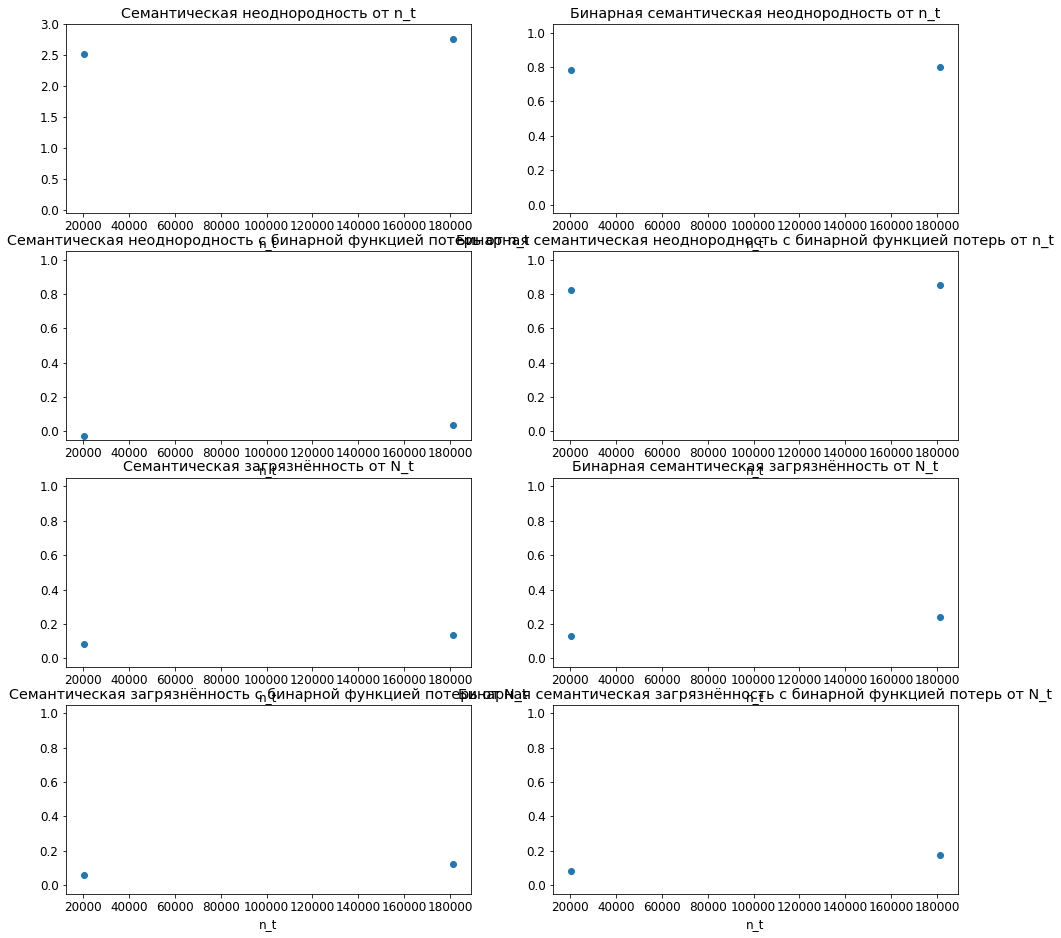

In [85]:
plt.figure(figsize=(16,16))

for ind, stat in enumerate(lenta_stat):
    plt.subplot(4, 2, ind + 1)
    plt.scatter(lenta_statistics.nt, stat)

    plt.xlabel('n_t')

    plt.title(titles[ind])

    if not ind:
        plt.ylim(-0.05, 3)
    else:
        plt.ylim(-0.05, 1.05)

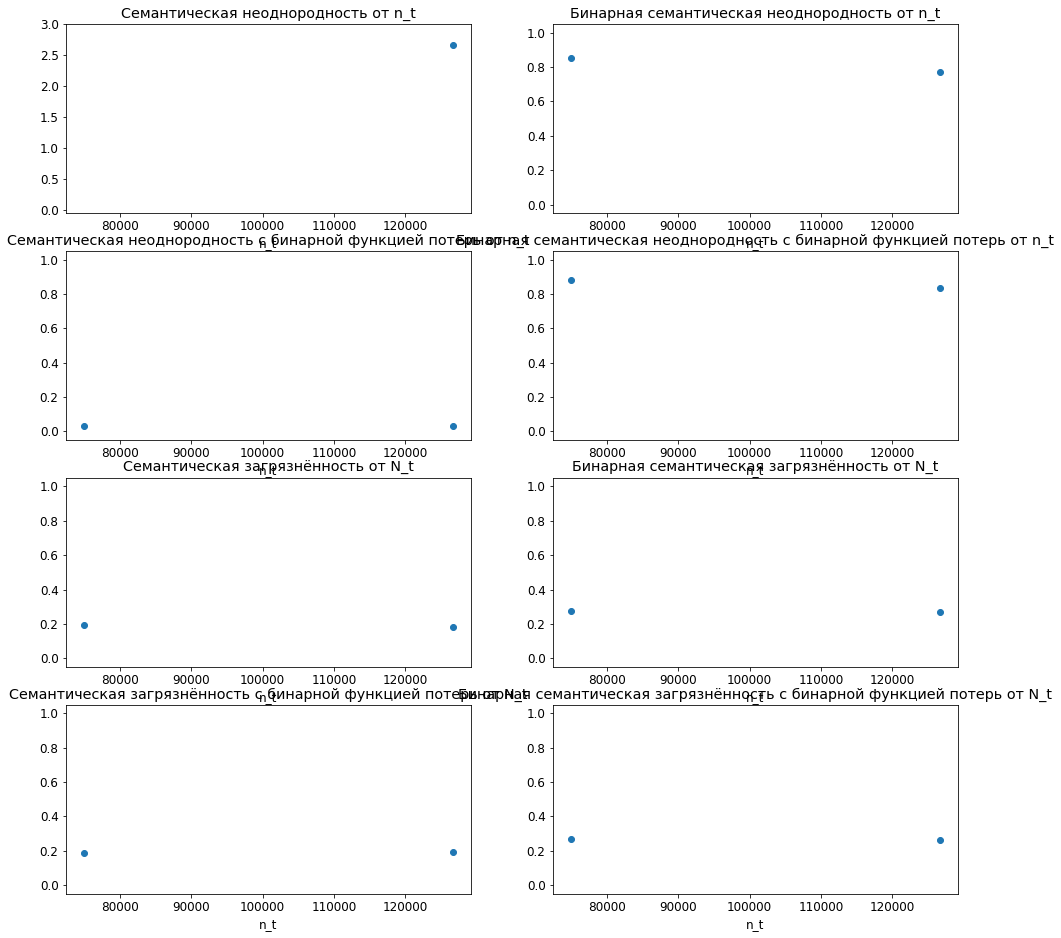

In [87]:
plt.figure(figsize=(16,16))

for ind, stat in enumerate(basic_lenta_stat):
    plt.subplot(4, 2, ind + 1)
    plt.scatter(basic_lenta_statistics.nt, stat)

    plt.xlabel('n_t')

    plt.title(titles[ind])

    if not ind:
        plt.ylim(-0.05, 3.15)
    else:
        plt.ylim(-0.05, 1.05)

## Lenta 22

In [108]:
DATA_PATH = '../data/lenta_22.vw'
BATCH_PATH = '../data/lenta_22_batches'
DICT_PATH = '../data/lenta_22.dict'

batch_vectorizer_lenta = artm.BatchVectorizer(
    data_path=DATA_PATH,
    data_format='vowpal_wabbit', 
    target_folder=BATCH_PATH
)

dictionary_lenta = artm.Dictionary()
if not os.path.isfile(DICT_PATH):
    dictionary_lenta.gather(data_path=batch_vectorizer_lenta.data_path)
    dictionary_lenta.save(DICT_PATH)
dictionary_lenta.load(DICT_PATH)

### Basic initialization

In [122]:
basic_model_lenta = artm.ARTM(num_topics=22, cache_theta=True)
basic_model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
basic_model_lenta.initialize(dictionary_lenta)

In [123]:
basic_model_lenta.fit_offline(batch_vectorizer_lenta, 15)

In [124]:
%%time 

basic_lenta_statistics = ModelStatistics(basic_model_lenta)
basic_lenta_stat = basic_lenta_statistics.calculate_topic_statistics(
    batch_vectorizer_lenta, calculate_n=True, recalculate_n=False
)

KeyboardInterrupt: 

### Perfect initialization

In [126]:
model_lenta = artm.ARTM(num_topics=22, cache_theta=True)
model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta.initialize(dictionary_lenta)

In [127]:
(_, old_pwt) = model_lenta.master.attach_model(model=model_lenta.model_pwt)

pwt = model_lenta.get_phi()

In [128]:
word2doc = calculate_word2doc(data_lenta['vw_text'], data_lenta.index)
doc2tag = dict(zip(data_lenta.index, data_lenta['tags']))

word2tag = calculate_word2tag(word2doc, doc2tag)

In [129]:
calc_pwt = calculate_ptw(word2doc, doc2tag, word2tag)
calc_pwt = calc_pwt.reindex(pwt.index)

In [130]:
np.copyto(old_pwt, calc_pwt)

### Fit and plot

In [ ]:
model_lenta.fit_offline(batch_vectorizer_lenta, 3)

lenta_statistics = ModelStatistics(model_lenta)
lenta_stat = lenta_statistics.calculate_topic_statistics(batch_vectorizer_lenta, calculate_n=True)

../library/statistics.py:126: RuntimeWarning: divide by zero encountered in log
  model_loss = np.log(self.phi.values / phi_safe)


In [142]:
titles = [
    'Семантическая неоднородность от n_t',
    'Бинарная семантическая неоднородность от n_t',
    'Семантическая неоднородность с бинарной функцией потерь от n_t',
    'Бинарная семантическая неоднородность с бинарной функцией потерь от n_t',
    'Семантическая загрязнённость от N_t',
    'Бинарная семантическая загрязнённость от N_t',
    'Семантическая загрязнённость с бинарной функцией потерь от N_t',
    'Бинарная семантическая загрязнённость с бинарной функцией потерь от N_t'
]

plt.rc('font', size=12)

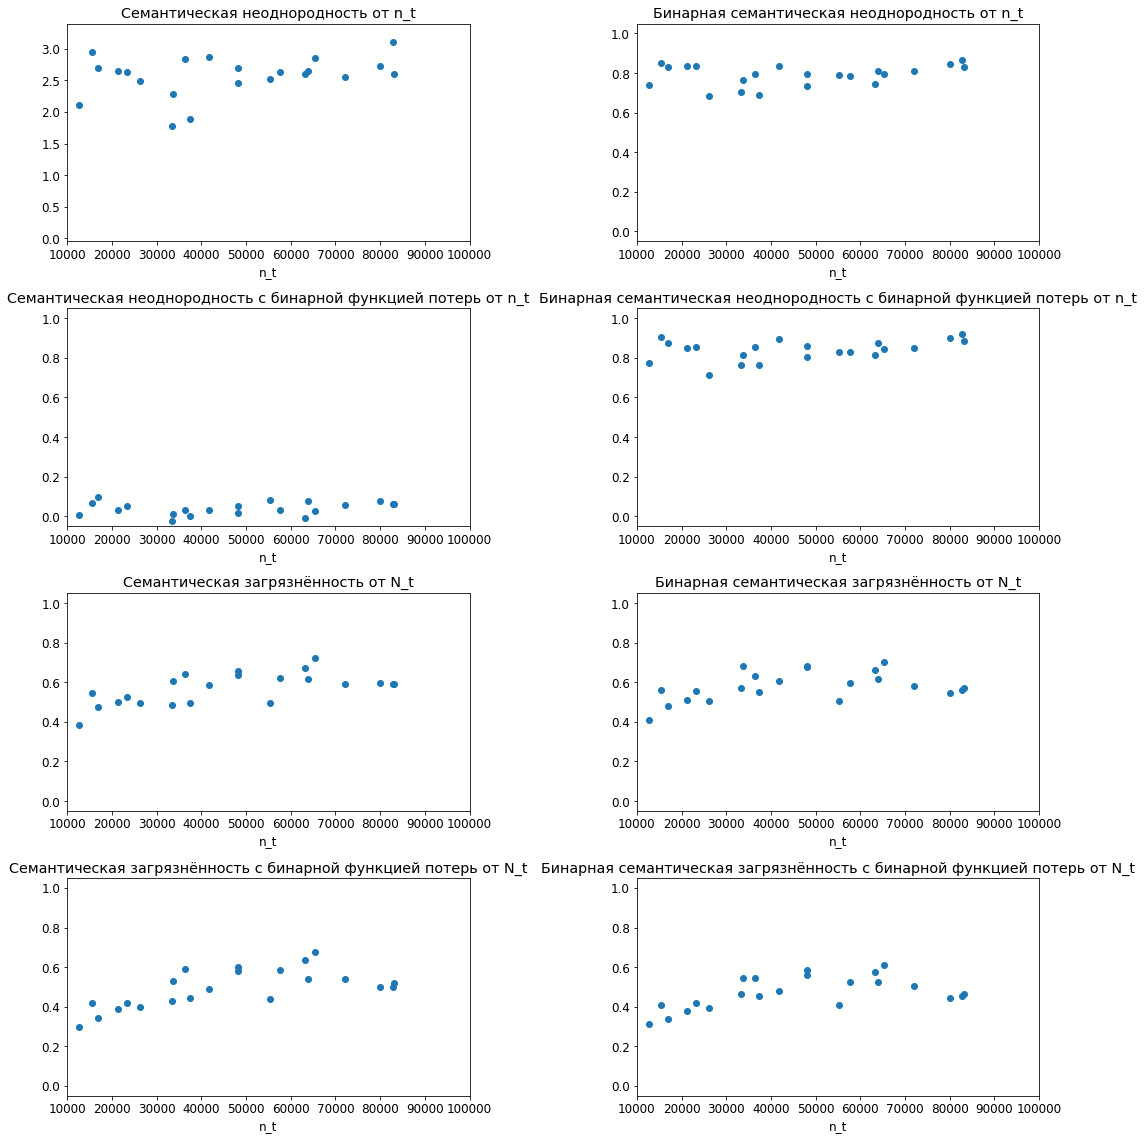

In [150]:
fig = plt.figure(figsize=(16,16))

for ind, stat in enumerate(lenta_stat):
    plt.subplot(4, 2, ind + 1)
    plt.scatter(lenta_statistics.nt, stat)

    plt.xlabel('n_t')

    plt.title(titles[ind])

    plt.xlim(10000, 100000)
    if not ind:
        plt.ylim(-0.05, 3.4)
    else:
        plt.ylim(-0.05, 1.05)

fig.tight_layout()
plt.savefig()

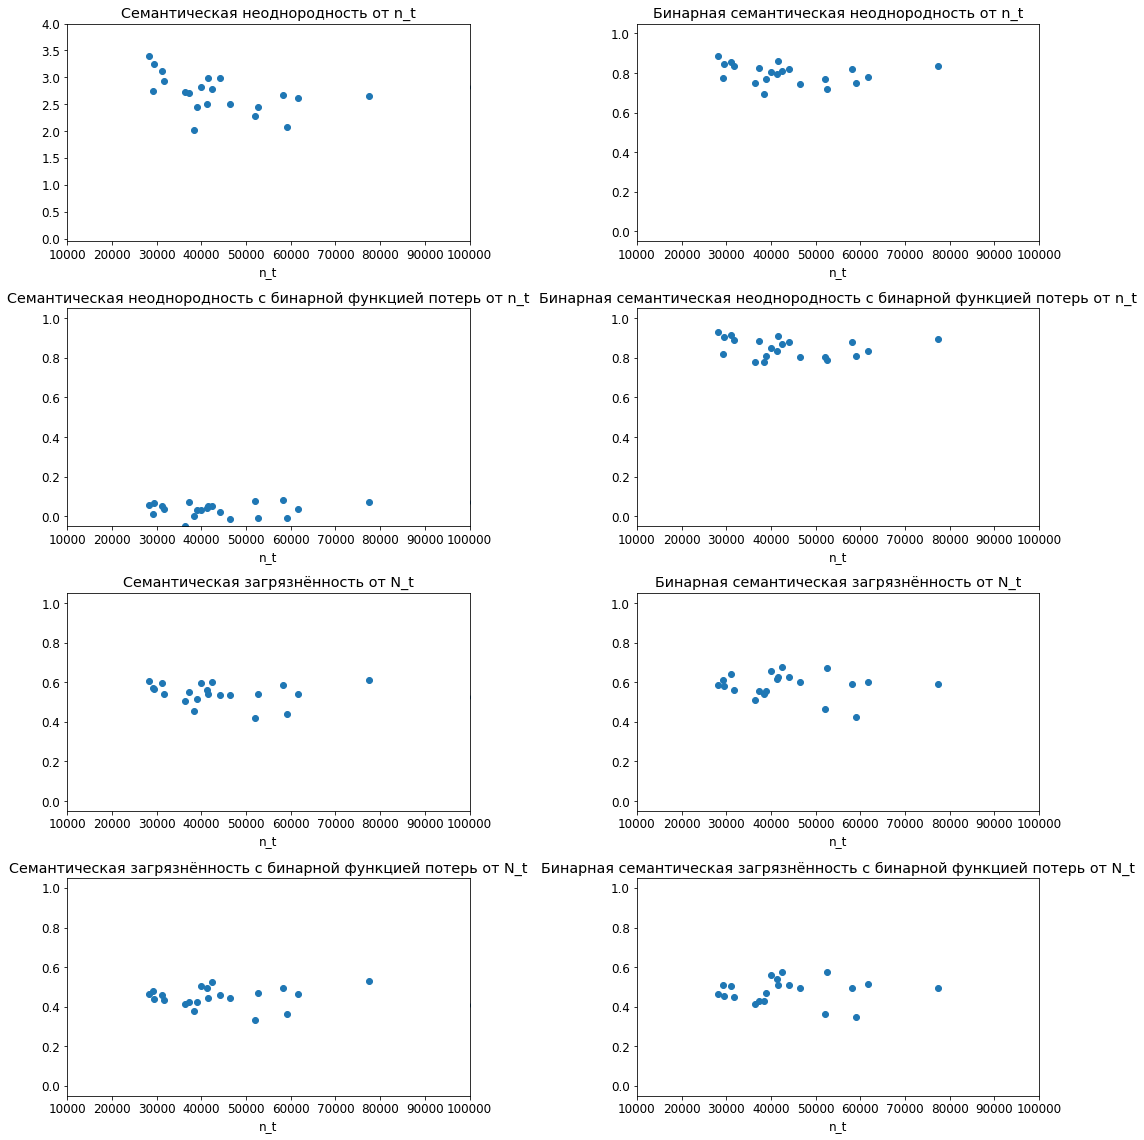

In [149]:
fig = plt.figure(figsize=(16,16))

for ind, stat in enumerate(basic_lenta_stat):
    plt.subplot(4, 2, ind + 1)
    plt.scatter(basic_lenta_statistics.nt, stat)

    plt.xlabel('n_t')

    plt.title(titles[ind])

    plt.xlim(10000, 100000)
    if not ind:
        plt.ylim(-0.05, 4)
    else:
        plt.ylim(-0.05, 1.05)
        
fig.tight_layout()

## Sample collection from $\Phi$ with 22 topics

### Lenta 1000 100

If model is not initialized:

In [125]:
DATA_PATH = '../data/lenta_1000_100.vw'
BATCH_PATH = '../data/lenta_1000_100_batches'
DICT_PATH = '../data/lenta_1000_100.dict'

batch_vectorizer_lenta = artm.BatchVectorizer(
    data_path=DATA_PATH,
    data_format='vowpal_wabbit', 
    target_folder=BATCH_PATH
)

dictionary_lenta = artm.Dictionary()
if not os.path.isfile(DICT_PATH):
    dictionary_lenta.gather(data_path=batch_vectorizer_lenta.data_path)
    dictionary_lenta.save(DICT_PATH)
dictionary_lenta.load(DICT_PATH)

In [127]:
basic_model_lenta = artm.ARTM(num_topics=2, cache_theta=True)
basic_model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
basic_model_lenta.initialize(dictionary_lenta)

In [128]:
basic_model_lenta.fit_offline(batch_vectorizer_lenta, 15)

In [129]:
%%time 

basic_lenta_statistics = ModelStatistics(basic_model_lenta)
basic_lenta_stat = basic_lenta_statistics.calculate_topic_statistics(
    batch_vectorizer_lenta, calculate_n=True, recalculate_n=False
)

../library/statistics.py:146: RuntimeWarning: divide by zero encountered in log
  model_loss = np.log(self.phi.values / phi_safe)


CPU times: user 1min 21s, sys: 1min 15s, total: 2min 36s
Wall time: 37.1 s


#### Sample documents

In [130]:
import random

In [132]:
phi = basic_model_lenta.get_phi()

topic_lens = [1000, 100]
topic_ids = []
for i in range(len(topic_lens)):
    topic_ids += [i for _ in range(topic_lens[i])]

In [133]:
collection = []

for doc_id, (topic_id, doc_len) in enumerate(zip(topic_ids, doc_lens)):
    phi_t = phi.iloc[:, topic_id].astype(np.float128)
    collection.append(f'{doc_id} |text ' + ' '.join(np.random.choice(
        phi.index, 
        int(doc_len), 
        p = (phi_t / phi_t.sum()).astype(np.float64)
    )))

In [134]:
OUTPUT_VW = '../data/sampled_lenta_1000_100.vw'

with open(OUTPUT_VW, 'w') as f:
    for elem in collection:
        f.write(elem + '\n')

#### Calculate statistics

In [139]:
DATA_PATH = '../data/sampled_lenta_1000_100.vw'
BATCH_PATH = '../data/sampled_lenta_1000_100_batches'
DICT_PATH = '../data/sampled_lenta_1000_100.dict'

batch_vectorizer_lenta = artm.BatchVectorizer(
    data_path=DATA_PATH,
    data_format='vowpal_wabbit', 
    target_folder=BATCH_PATH
)

dictionary_lenta = artm.Dictionary()
if not os.path.isfile(DICT_PATH):
    dictionary_lenta.gather(data_path=batch_vectorizer_lenta.data_path)
    dictionary_lenta.save(DICT_PATH)
dictionary_lenta.load(DICT_PATH)

In [140]:
basic_model_lenta = artm.ARTM(num_topics=2, cache_theta=True)
basic_model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
basic_model_lenta.initialize(dictionary_lenta)

basic_model_lenta.fit_offline(batch_vectorizer_lenta, 15)

In [141]:
%%time 

basic_lenta_statistics = ModelStatistics(basic_model_lenta)
basic_lenta_stat = basic_lenta_statistics.calculate_topic_statistics(
    batch_vectorizer_lenta, calculate_n=True, recalculate_n=False
)

../library/statistics.py:146: RuntimeWarning: divide by zero encountered in log
  model_loss = np.log(self.phi.values / phi_safe)


CPU times: user 1min 18s, sys: 1min 12s, total: 2min 30s
Wall time: 35.7 s


In [157]:
def plot_statistics(statistics, calculated_statistics, plotname=None):
    titles = [
        'Семантическая неоднородность от n_t',
        'Бинарная семантическая неоднородность от n_t',
        'Семантическая неоднородность с бинарной функцией потерь от n_t',
        'Бинарная семантическая неоднородность с бинарной функцией потерь от n_t',
        'Семантическая загрязнённость от N_t',
        'Бинарная семантическая загрязнённость от N_t',
        'Семантическая загрязнённость с бинарной функцией потерь от N_t',
        'Бинарная семантическая загрязнённость с бинарной функцией потерь от N_t'
    ]

    plt.rc('font', size=12)
    fig = plt.figure(figsize=(16,16))

    for ind, stat in enumerate(calculated_statistics):
        plt.subplot(4, 2, ind + 1)
        plt.scatter(statistics.nt, stat)

        plt.xlabel('n_t')

        plt.title(titles[ind])

        if not ind:
            plt.ylim(-0.05, calculated_statistics[0].max() + 0.2)
        else:
            plt.ylim(-0.05, 1.05)

    fig.tight_layout()
    
    if plotname:
        plt.savefig(plotname)

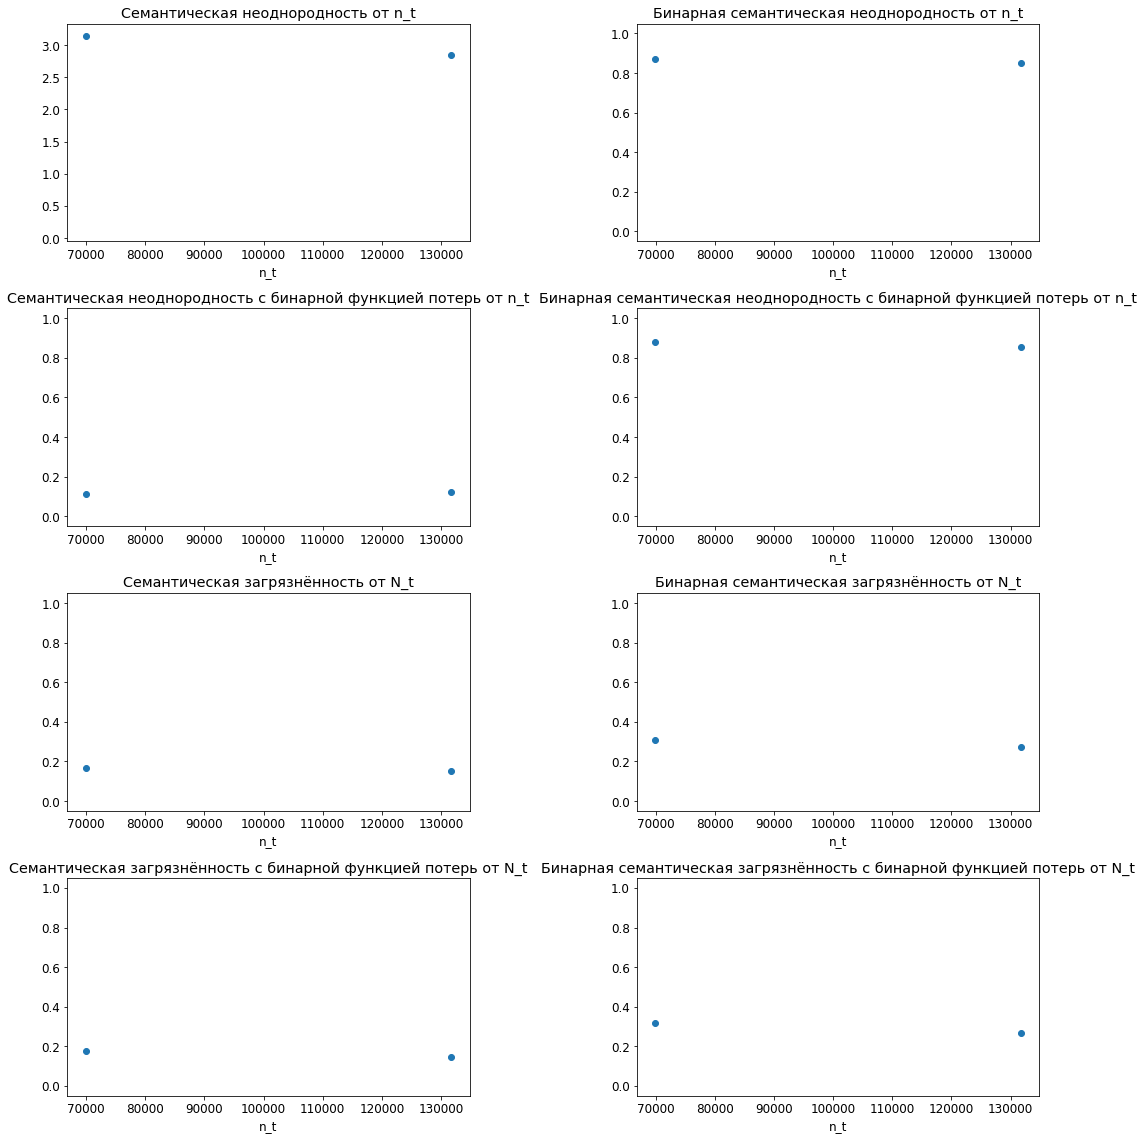

In [158]:
plot_statistics(basic_lenta_statistics, basic_lenta_stat, 'sampled_1000_100')

#### Lenta 22

If model is not initialized:

In [143]:
%%time 

DATA_PATH = '../data/lenta_22.vw'
BATCH_PATH = '../data/lenta_22_batches'
DICT_PATH = '../data/lenta_22.dict'

batch_vectorizer_lenta = artm.BatchVectorizer(
    data_path=DATA_PATH,
    data_format='vowpal_wabbit', 
    target_folder=BATCH_PATH
)

dictionary_lenta = artm.Dictionary()
if not os.path.isfile(DICT_PATH):
    dictionary_lenta.gather(data_path=batch_vectorizer_lenta.data_path)
    dictionary_lenta.save(DICT_PATH)
dictionary_lenta.load(DICT_PATH)

model_lenta = artm.ARTM(num_topics=22, cache_theta=True)
model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta.initialize(dictionary_lenta)

model_lenta.fit_offline(batch_vectorizer_lenta, 15)

lenta_statistics = ModelStatistics(model_lenta)
lenta_stat = lenta_statistics.calculate_topic_statistics(
    batch_vectorizer_lenta, calculate_n=True, recalculate_n=False
)

../library/statistics.py:146: RuntimeWarning: divide by zero encountered in log
  model_loss = np.log(self.phi.values / phi_safe)


CPU times: user 27min 25s, sys: 24min 27s, total: 51min 53s
Wall time: 10min 58s


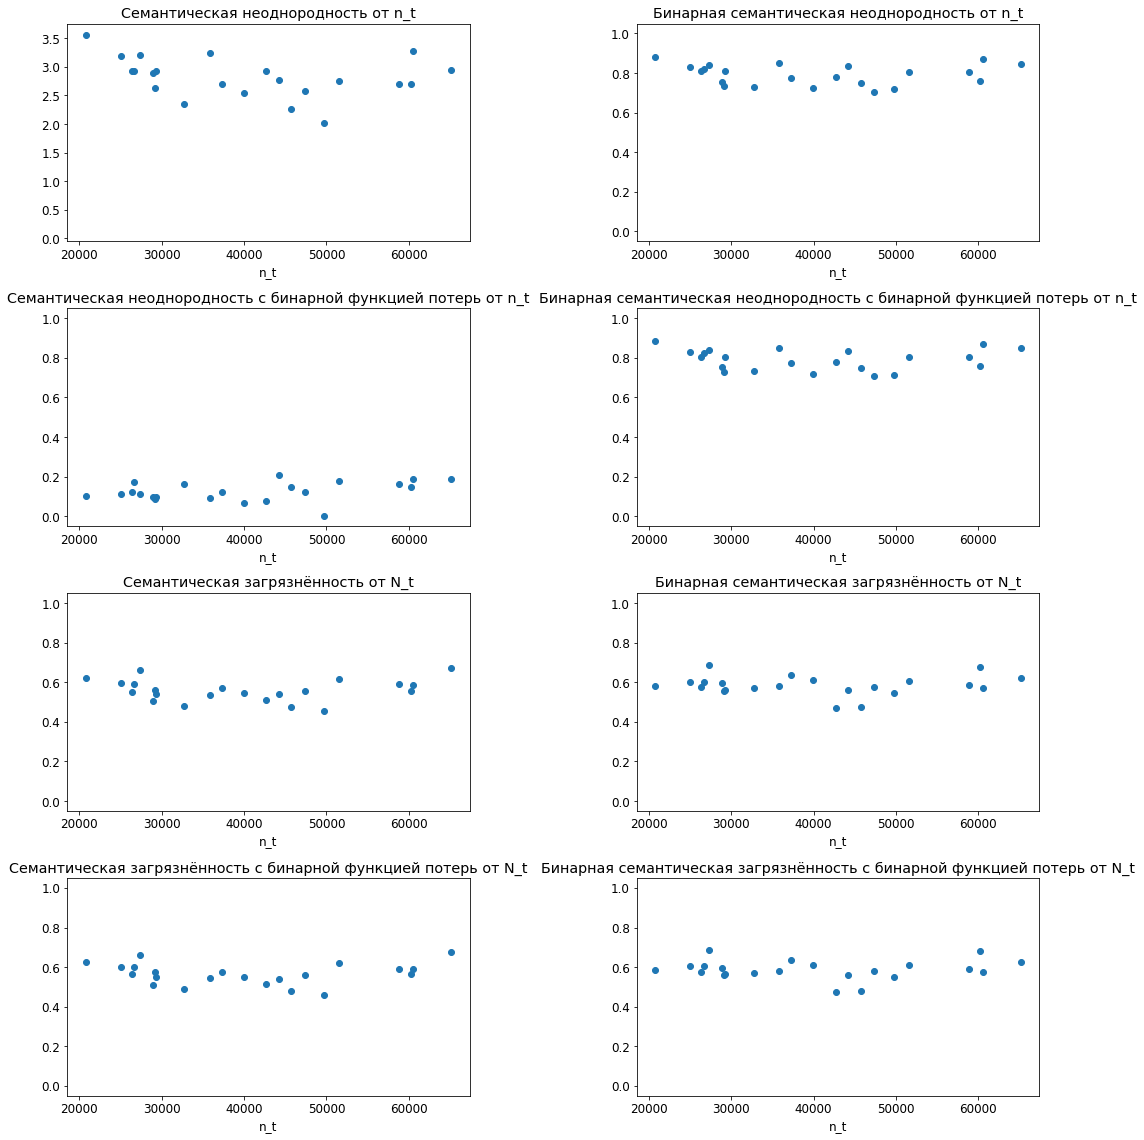

In [160]:
plot_statistics(lenta_statistics, lenta_stat, 'real_22')

#### Sample documents

In [144]:
topic_lens = [300] * 10 + [500] * 6 + [85] * 6
topic_ids = []
for i in range(len(topic_lens)):
    topic_ids += [i for _ in range(topic_lens[i])]

doc_lens = basic_lenta_statistics.nwd.sum(axis=0)
random.shuffle(doc_lens)

phi = model_lenta.get_phi()

In [145]:
collection = []

for doc_id, (topic_id, doc_len) in enumerate(zip(topic_ids, doc_lens)):
    phi_t = phi.iloc[:, topic_id].astype(np.float128)
    collection.append(f'{doc_id} |text ' + ' '.join(np.random.choice(
        phi.index, 
        int(doc_len), 
        p = (phi_t / phi_t.sum()).astype(np.float64)
    )))

In [146]:
OUTPUT_VW = '../data/sampled_lenta_22.vw'

with open(OUTPUT_VW, 'w') as f:
    for elem in collection:
        f.write(elem + '\n')

#### Calculate statistics

In [147]:
DATA_PATH = '../data/sampled_lenta_22.vw'
BATCH_PATH = '../data/sampled_lenta_22_batches'
DICT_PATH = '../data/sampled_lenta_22.dict'

sampled_batch_vectorizer_lenta = artm.BatchVectorizer(
    data_path=DATA_PATH,
    data_format='vowpal_wabbit', 
    target_folder=BATCH_PATH
)

sampled_dictionary_lenta = artm.Dictionary()
if not os.path.isfile(DICT_PATH):
    sampled_dictionary_lenta.gather(data_path=sampled_batch_vectorizer_lenta.data_path)
    sampled_dictionary_lenta.save(DICT_PATH)
sampled_dictionary_lenta.load(DICT_PATH)

sampled_model_lenta = artm.ARTM(num_topics=22, cache_theta=True)
sampled_model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
sampled_model_lenta.initialize(sampled_dictionary_lenta)

sampled_model_lenta.fit_offline(sampled_batch_vectorizer_lenta, 15)

sampled_lenta_statistics = ModelStatistics(sampled_model_lenta)
sampled_lenta_stat = sampled_lenta_statistics.calculate_topic_statistics(
    sampled_batch_vectorizer_lenta, calculate_n=True, recalculate_n=False
)

../library/statistics.py:146: RuntimeWarning: divide by zero encountered in log
  model_loss = np.log(self.phi.values / phi_safe)


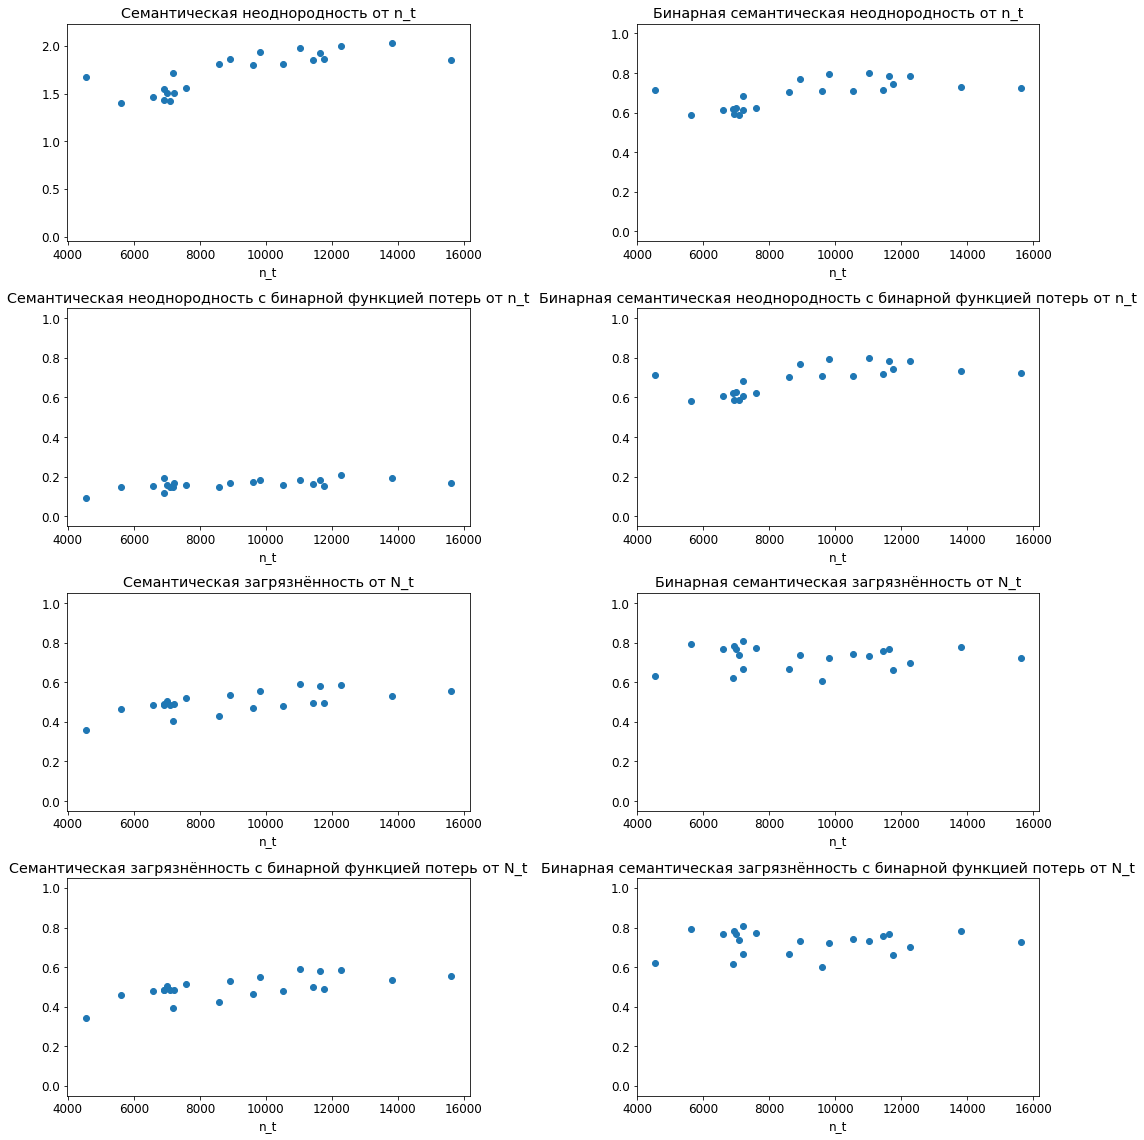

In [159]:
plot_statistics(sampled_lenta_statistics, sampled_lenta_stat, 'sampled_22')